# Imports

In [1]:
# Data manipulation
import pandas as pd
import geopandas as gpd
import fiona
import numpy as np
import pickle
import copy
import geodata

# Visualization
import matplotlib
import matplotlib.pyplot as plt
import matplotlib.cm as cm
import matplotlib.patches as mpatches
import matplotlib.ticker as mtick
from matplotlib.lines import Line2D
from matplotlib.artist import Artist
import seaborn as sns

# Machine learning & statistics
from sklearn.cluster import KMeans
from sklearn.metrics import silhouette_samples, silhouette_score
from sklearn.neighbors import NearestNeighbors
from scipy import stats
from sklearn_extra.cluster import KMedoids
from sklearn.preprocessing import StandardScaler
from sklearn.cluster import KMeans

# Other
import time
from itertools import product
from itertools import compress
import random

In [2]:
from IPython.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

# Initial Parameters

In [3]:
testSize = 10000
testing = True #Set True if only the first *testSize* Trips will be considered (for tesing)

clusters = 10

printPlots = False #Set true if you want to print some plots

charging_power = 11
spec_consump = {"2020": 0.13034957241869252, "2030": 0.19699600229856518, "2045": 0.1082373398053683}  # kWh/km
scenario = "2030"
days = {0: "Wochenende", 1: "Wochentag"}
days_eng = {0: "weekends", 1: "weekdays"}

In [4]:
# Pickle Checkpoint Settings
# CP1: households_df, mop_trips_df, trip_chain_df, trip_arrival_location_df
savingCP1 = False
loadingCP1 = False

# CP2: complete_df
savingCP2 = False
loadingCP2 = False

# CP3: parking_time_df, parking_time_by_location_df and load
savingCP3 = False
loadingCP3 = False

# Data Preperation

### Household Data

In [7]:
# Load households_df data
households_df = pd.read_pickle("data/households_df.pickle")

### Trip Data

In [8]:
# Load trip data
mop_trips_df = pd.read_pickle("./Output/temp_saves/mop_trips_df.pickle")

# Filter trip data
mop_trips_df = mop_trips_df[(mop_trips_df["VMDIW"].isin([4, 41]))] # only consider ways by car and as a driver
mop_trips_df = mop_trips_df[mop_trips_df.VM2.isna()] # 
mop_trips_df = mop_trips_df[~(mop_trips_df["KM"].isna())] # remove rides without KM info

# Add region information to trip data
mop_trips_df.loc[:, "BIK"] = mop_trips_df["ID"].apply(lambda x: households_df.loc[x, "BIK"]).values
mop_trips_df.loc[:, "LAGE"] = mop_trips_df["ID"].apply(lambda x: households_df.loc[x, "LAGE"]).values

# ID for trip chain
mop_trips_df["ID_PERSNR_BERTAG"] = mop_trips_df["ID"].astype(str) + "_" + mop_trips_df["JAHR"].astype(str) + "_" + mop_trips_df["PERSNR"].astype(str) + "_" + mop_trips_df["BERTAG"].astype(str)

# Calculate energy consumption of each trip in kWh
mop_trips_df["ENERGY_kWh"] = mop_trips_df.KM * spec_consump[scenario]

# Fix ANZEIT = 0, because 0 actually represents 24:00 and not 00:00.
mop_trips_df.loc[mop_trips_df["ANZEIT"] == 0, "ANZEIT"] = 2400

# Set last time slot
mop_trips_df.loc[mop_trips_df["ANZEIT"] == 2400, "ANZEIT"] = 2359

# Used for later trip chain done with pivot table
mop_trips_df["ANZEIT_bool"] = 2
mop_trips_df["ANZEIT"] = mop_trips_df["ANZEIT"].astype(int)
mop_trips_df["ABZEIT_bool"] = 1
mop_trips_df["ABZEIT"] = mop_trips_df["ABZEIT"].astype(int)

# Calculate arrival and departure times in minutes and hours
for i in ["ANZEIT", "ABZEIT"]:
    mop_trips_df["{}_minutes".format(i)] = mop_trips_df[i].apply(lambda x: int("".join(["0" for i in range(4 - len(str(x)))] + [str(x)])[:2]) * 60 + np.floor(int("".join(["0" for i in range(4 - len(str(x)))] + [str(x)])[2:])))
    mop_trips_df["{}_hours".format(i)] = mop_trips_df[i].apply(lambda x: int("".join(["0" for i in range(4 - len(str(x)))] + [str(x)])[:2]))

# mop_trips_df

In [41]:
if testing:
    mop_trips_df = mop_trips_df.tail(testSize)

### Generating Trip Chain
and also save the arrival location with the following Coding:

- 1- Workplace
- 2- Home
- 3- Other


In [42]:
"""
For clarification:
We have arrival times marked with the value 2 and departure times with 1 in the columns "ANZEIT_bool" and "ABZEIT_bool", respectively.
We then create pivot tables from these, using "ID_PERSNR_BERTAG" as the index, and add them together.
If an arrival and departure happen in the same minute, the resulting value is set to 0, meaning the trip is deleted.
"""

# get trip chain
trip_chain_df = pd.pivot_table(mop_trips_df, index="ID_PERSNR_BERTAG", columns="ANZEIT", values="ANZEIT_bool", fill_value=0).add(pd.pivot_table(mop_trips_df, index="ID_PERSNR_BERTAG", columns="ABZEIT", values="ABZEIT_bool", fill_value=0),fill_value=0).reindex(columns=[int(str(i).split(" ")[-1].replace(":", "")[:4]) for i in pd.date_range("00:00:00", "23:59:00", freq="min")], fill_value=0)
# control for rides starting in same minute as previous ride ends (results in "3" in DataFrame)
trip_chain_df = trip_chain_df.replace(3, 0)

In [43]:
# Place of arrival as a pivot table
trip_arrival_location_df = pd.pivot_table(mop_trips_df, index="ID_PERSNR_BERTAG", columns="ANZEIT", values="ZWECK", fill_value=0).reindex(columns=[int(str(i).split(" ")[-1].replace(":", "")[:4]) for i in pd.date_range("00:00:00", "23:59:00", freq="min")], fill_value=0)

In [44]:
# Rename some columns in trip data and pivot table based on mappings defined in Excel file
rename_zweck = pd.read_excel("data//Zuordnung MOP.xlsx", "Zweck")
mop_trips_df.loc[:,"ZWECK"] = mop_trips_df["ZWECK"].replace(dict(zip(rename_zweck["Code"], rename_zweck["Code_new"])))
trip_arrival_location_df = trip_arrival_location_df.replace(dict(zip(rename_zweck["Code"], rename_zweck["Code_new"])))

rename_gemeinde = pd.read_excel("data//Zuordnung MOP.xlsx","BIK")
mop_trips_df.loc[:,"BIK"] = mop_trips_df["BIK"].replace(dict(zip(rename_gemeinde["Code"], rename_gemeinde["Code_new"])))

### Pickle Save [Checkpoint 1]
Saving "households_df", "mop_trips_df", "trip_chain_df" abd "trip_arrival_location_df".

In [45]:
if savingCP1:
    households_df.to_pickle("./Output/temp_saves/households_df_cp1.pickle")
    mop_trips_df.to_pickle("./Output/temp_saves/mop_trips_df_cp1.pickle")
    trip_chain_df.to_pickle("./Output/temp_saves/trip_chain_df_cp1.pickle")
    trip_arrival_location_df.to_pickle("./Output/nick/temp_saves/trip_arrival_location_df_cp1.pickle")
    print("Saved mop_trips_df, trip_chain_df and trip_arrival_location_df to /Output/temp_saves")

In [46]:
if loadingCP1:
    households_df = pd.read_pickle("./Output/temp_saves/households_df_cp1.pickle")
    mop_trips_df = pd.read_pickle("./Output/temp_saves/mop_trips_df_cp1.pickle")
    trip_chain_df = pd.read_pickle("./Output/temp_saves/trip_chain_df_cp1.pickle")
    trip_arrival_location_df = pd.read_pickle("./Output/temp_saves/trip_arrival_location_df_cp1.pickle")
    print("Loaded mop_trips_df, trip_chain_df and trip_arrival_location_df from /Output/temp_saves")

### The "complete_df"
Creting the "complete_df", which contains for every ID_{Jahr_}PERSNR_BERTAG the relevant trip information

In [47]:
"""
Explanation:
Combine multiple trips on a single day for each ID_{Year_}PERSNR_BERTAG into one column using a list.
"""

complete_df = pd.DataFrame([], index=mop_trips_df["ID_PERSNR_BERTAG"].drop_duplicates())
for col in ["ANZEIT", "ABZEIT", "BIK", "KM", "ENERGY_kWh", "ZWECK", "WOTAG"]:
    complete_df.loc[:, col] = mop_trips_df.groupby("ID_PERSNR_BERTAG")[col].apply(list)
    
# Set values to that value if they are the same for all entries in the lists.
complete_df["BIK"] = complete_df["BIK"].apply(lambda x: x[0])
complete_df["WOTAG"] = complete_df["WOTAG"].apply(lambda x: x[0])

# set weekday=1 and weekend=0
complete_df.loc[complete_df.WOTAG <= 5, "WOTAG"] = 1
complete_df.loc[complete_df.WOTAG > 5, "WOTAG"] = 0

In [48]:
# Add the arrival time in minutes (to make it easier to calculate the standing duration).
for i in ["ANZEIT", "ABZEIT"]:
    complete_df["{}_minutes".format(i)] = mop_trips_df.groupby("ID_PERSNR_BERTAG")["{}_minutes".format(i)].apply(list)

In [49]:
# Sort departure times correctly.
complete_df["ABZEIT_minutes"] = complete_df["ABZEIT_minutes"].apply(sorted)
# Sort arrival times correctly.
complete_df["ANZEIT_minutes"] = complete_df["ANZEIT_minutes"].apply(sorted)

In [50]:
"""
Calculating the parking times
Example with two trips: [parking time for purpose[0], parking time for purpose[1]]
The last purpose is always 2; similarly, the last parking time is always the one before the first departure and after the last arrival.
"""

drop = []
complete_df["STANDZEIT"] = complete_df.apply(lambda x: [], axis=1)

for num, i in complete_df.iterrows():
    i["ABZEIT_minutes"].append(i["ABZEIT_minutes"].pop(0))
    if len(i["ABZEIT_minutes"]) < len(i["ANZEIT_minutes"]):
        drop.append(num)
        continue
    elif len(i["ABZEIT_minutes"]) > len(i["ANZEIT_minutes"]):
        drop.append(num)
        continue
    for j in range(len(i["ANZEIT_minutes"])):
        complete_df.loc[num, "STANDZEIT"].append(i["ABZEIT_minutes"][j]-i["ANZEIT_minutes"][j])
        if complete_df.loc[num, "STANDZEIT"][-1] < 0:
            complete_df.loc[num, "STANDZEIT"][-1] = 24*60 + complete_df.loc[num, "STANDZEIT"][-1]        

In [51]:
# Sort departure times correctly again."
complete_df["ABZEIT_minutes"] = complete_df["ABZEIT_minutes"].apply(sorted)

In [52]:
"""
Calculate the travel times.
"""
drop = []
complete_df["FAHRTZEIT"] = complete_df.apply(lambda x: [], axis=1)

for num, i in complete_df.iterrows():
    #Sort lists
    abfahrtszeiten = sorted(i["ABZEIT_minutes"])
    ankunftszeiten = sorted(i["ANZEIT_minutes"])

    if len(abfahrtszeiten) != len(ankunftszeiten):
        drop.append(num)
        print("Error")
        continue
    for j in range(len(abfahrtszeiten)):
        complete_df.loc[num, "FAHRTZEIT"].append(ankunftszeiten[j] - abfahrtszeiten[j]) 

In [53]:
"""
Remove values where negative parking or travel times occurred during calculation.
This could happen, for example, if the first arrival time is before the first departure time — which should not occur.
Therefore, such entries are removed.
"""
complete_df_fails = pd.DataFrame()

for index, row in complete_df.iterrows():
    if any(val < 0 for val in row['FAHRTZEIT']) or any(val < 0 for val in row['STANDZEIT']):
        complete_df_fails = pd.concat([complete_df_fails, pd.DataFrame(row).transpose()])
        complete_df = complete_df.drop(index)
print(f"There are {len(complete_df_fails)} wrong values. These were deleted.")


There are 1 wrong values. These were deleted.


In [54]:
# complete_df_fails

In [55]:
"""
Check the parking time and travel time calculations.
"""

def check_total_time(df):
    incorrect_df = pd.DataFrame()
    correct_df = df.copy()
    for num, row in df.iterrows():
        total_time = sum(row["STANDZEIT"]) + sum(row["FAHRTZEIT"])
        if total_time != 1440:
            print(f"Row {num} is nor corrext. Total time is {total_time} minutes. This entry was removed.")
            incorrect_df = pd.concat([incorrect_df, pd.DataFrame(row).transpose()])
            correct_df = correct_df.drop(num)
    print("The total time is 1440 minutes for each correct row.")
    return correct_df, incorrect_df

# Call function
complete_df, incorrect_df = check_total_time(complete_df)
print(incorrect_df.head())

The total time is 1440 minutes for each correct row.
Empty DataFrame
Columns: []
Index: []


In [56]:
# define all charging_combinations for charging locations
# tuples = (Workplace, Home, Public)
tuples = [1, 2, 3]
charging_combinations = list(set([(i, j, k) for i in [0, 1] for j in [0, 1] for k in [0, 1]]))
charging_combinations.remove((0, 0, 0))

In [57]:
"""
For the different possible charging locations (1 = possible, 0 = not possible) for {Work, Home, Public}, calculate the following:
ENERGY_kWh_( , , ) → energy needed
VOLLLADUNG_min_( , , ) → time until the battery is fully charged (in minutes)
charging_kWh_( , , ) → charging time series
"""

def shift_energy_location(data, charge_spot, charge):
    for index in range(len(data["ZWECK"])):
        if data["STANDZEIT"][index] < data["VOLLLADUNG_min_" + str(charge).replace(" ", "")][index]:
            if index < len(data["ZWECK"]) - 1:
                data["ENERGY_kWh_" + str(charge).replace(" ", "")][index + 1] += data["ENERGY_kWh_" + str(charge).replace(" ", "")][index] - data["STANDZEIT"][index] * charging_power / 60
                data["VOLLLADUNG_min_" + str(charge).replace(" ", "")][index + 1] = np.ceil((data["ENERGY_kWh_" + str(charge).replace(" ", "")][index + 1] / (charging_power / 60)))
            else:
                data["ENERGY_kWh_" + str(charge).replace(" ", "")][0] += data["ENERGY_kWh_" + str(charge).replace(" ", "")][index] - data["STANDZEIT"][index] * charging_power / 60
                data["VOLLLADUNG_min_" + str(charge).replace(" ", "")][0] = np.ceil((data["ENERGY_kWh_" + str(charge).replace(" ", "")][0] / (charging_power / 60)))
            data["ENERGY_kWh_" + str(charge).replace(" ", "")][index] = data["STANDZEIT"][index] * charging_power / 60
            data["VOLLLADUNG_min_" + str(charge).replace(" ", "")][index] = data["STANDZEIT"][index]
        if (data["ZWECK"][index] not in charge_spot) and (data["ENERGY_kWh_" + str(charge).replace(" ", "")][index] > 0):
            # try to shift energy to next trip
            if index < len(data["ZWECK"]) - 1:
                data["ENERGY_kWh_" + str(charge).replace(" ", "")][index + 1] += data["ENERGY_kWh_" + str(charge).replace(" ", "")][index]
                data["VOLLLADUNG_min_" + str(charge).replace(" ", "")][index + 1] = np.ceil((data["ENERGY_kWh_" + str(charge).replace(" ", "")][index + 1] / (charging_power / 60)))
                data["ENERGY_kWh_" + str(charge).replace(" ", "")][index] = 0
                data["VOLLLADUNG_min_" + str(charge).replace(" ", "")][index] = 0
            else:
                # shift charging to trip in beginning if no possible location available
                data["ENERGY_kWh_" + str(charge).replace(" ", "")][0] += data["ENERGY_kWh_" + str(charge).replace(" ", "")][index]
                data["VOLLLADUNG_min_" + str(charge).replace(" ", "")][0] = np.ceil((data["ENERGY_kWh_" + str(charge).replace(" ", "")][0] / (charging_power / 60)))
                data["ENERGY_kWh_" + str(charge).replace(" ", "")][index] = 0
                data["VOLLLADUNG_min_" + str(charge).replace(" ", "")][index] = 0
                data["ENERGY_kWh_" + str(charge).replace(" ", "")] = shift_energy_location(data.copy(), charge_spot,charge)

    return data["ENERGY_kWh_" + str(charge).replace(" ", "")]

for charge in charging_combinations:
    charge_spot = list(compress(tuples, charge))
    complete_df.loc[:, "ENERGY_kWh_" + str(charge).replace(" ", "")] = complete_df.apply(lambda x: [], axis=1)
    # copy inital energy demand list
    for day in complete_df.index:
        for kWh in complete_df.loc[day, "ENERGY_kWh"]:
            complete_df.loc[day, "ENERGY_kWh_" + str(charge).replace(" ", "")].append(kWh)

    # calculate time until battery is fully charged (minutes)
    complete_df.loc[:, "VOLLLADUNG_min_" + str(charge).replace(" ", "")] = complete_df["ENERGY_kWh_" + str(charge).replace(" ", "")].dropna().apply(lambda x: [np.ceil((i / (charging_power / 60))) for i in x])

    for i in complete_df.index:
        # just consider trip_chain_df if charging for combination possible at all or if electricity demand that cannot be covered
        if not any(tuple([True for j in charge_spot if j in complete_df.loc[i, "ZWECK"]])) or sum([complete_df.loc[i, "STANDZEIT"][num] for num, j in enumerate(complete_df.loc[i, "ZWECK"]) if j in charge_spot] - sum(complete_df.loc[i, "VOLLLADUNG_min_" + str(charge).replace(" ", "")])) < 0:
            complete_df.loc[i, "ENERGY_kWh_" + str(charge).replace(" ", "")] = np.nan
            continue
        # shift energy according to locations
        output = shift_energy_location(complete_df.loc[i].copy(), charge_spot, charge)
        # store new charging needs
        for num, j in enumerate(output):
            complete_df.loc[i, "ENERGY_kWh_" + str(charge).replace(" ", "")][num] = j

    # calculate time until battery is fully charged (minutes) after changes
    complete_df.loc[:, "VOLLLADUNG_min_" + str(charge).replace(" ", "")] = complete_df["ENERGY_kWh_" + str(charge).replace(" ", "")].dropna().apply(lambda x: [np.ceil((i / (charging_power / 60))) for i in x])

    # calculate charging time series
    complete_df.loc[:, "charging_kWh_" + str(charge).replace(" ", "")] = complete_df["ENERGY_kWh_" + str(charge).replace(" ", "")].dropna().apply(lambda x: [[min(charging_power / 60, i - num * (charging_power / 60)) for num in range(int(np.ceil(i / (charging_power / 60))))] for i in x])

### Pickle Save [Checkpoint 2]
Saving the "complete_df" dataframe.

In [58]:
if savingCP2:
    complete_df.to_pickle("./Output/temp_saves/complete_df_cp2.pickle")
    print("Saved complete_df to /Output/temp_saves")

In [59]:
if loadingCP2:
    complete_df = pd.read_pickle("./Output/temp_saves/complete_df_cp2.pickle")
    print("Loaded complete_df from /Output/temp_saves")

# Parking Time
Generates park_time_by_location_df

In [60]:
"""
Creates a DataFrame with all minutes of the day as columns and, for each ID_{Year_}PERSNR_BERTAG, a 0 if the vehicle is not parked, and depending on the parking location, one of the following codes:
1 = Work
2 = Home
3 = Other
"""
park_time_by_location_df = trip_chain_df.copy()
def set_status(x):
    list_parking = [0 for i in x]
    indicator = 0
    count = 2
    x = x.replace(1, "Abfahrt")
    x = x.replace(2, "Ankunft")

    for j in range(count):
        for num, i in enumerate(x):
            if i == "Abfahrt":
                indicator = 0
            elif i == "Ankunft":
                indicator = trip_arrival_location_df.loc[x.name].iloc[num]
            list_parking[num] = indicator
    return tuple(list_parking)

park_time_by_location_df = pd.DataFrame(park_time_by_location_df.apply(set_status, axis=1).apply(pd.Series))
park_time_by_location_df.columns = [i for i in range(1440)]
park_time_by_location_df_all = park_time_by_location_df.apply(pd.Series.value_counts)  # .loc[[0,1,2,3]]

# Driving Time & Driving Profiles
Generates driving_time_df & driving_distance_df

In [61]:
"""
Creates a DataFrame with all minutes of the day as columns and, for every ID_{Year_}PERSNR_BERTAG, a 1 if the car is currently driving.
"""
driving_time_df = trip_chain_df.copy()
def set_driving_status(x):
    list_driving = [0 for i in x]
    indicator = 0
    count = 2
    x = x.replace(1, "Abfahrt")
    x = x.replace(2, "Ankunft")

    for j in range(count):
        for num, i in enumerate(x):
            if i == "Abfahrt":
                indicator = 1
            elif i == "Ankunft":
                indicator = 0
            list_driving[num] = indicator
    return tuple(list_driving)

driving_time_df = pd.DataFrame(driving_time_df.apply(set_driving_status, axis=1).apply(pd.Series))
driving_time_df.columns = [i for i in range(1440)]

In [62]:
driving_time_df.loc[["9311060266_2020_2_3", "9311060266_2020_2_4"], 390:400]

,390,391,392,393,394,395,396,397,398,399,400
ID_PERSNR_BERTAG,,,,,,,,,,,
9311060266_2020_2_3,0,0,0,1,1,1,1,1,1,1,1
9311060266_2020_2_4,0,0,0,0,0,1,1,1,1,1,1


In [63]:
"""
Creates a DataFrame with all minutes of the day as columns and, for each ID_{Year_}PERSNR_BERTAG, the kilometers driven in that minute.
"""
def set_driving_distance(row):
    list_driving_distance = [0 for _ in range(1440)]
    # Iterate through each trip.
    for start_time, end_time, trip_length in zip(row["ABZEIT_minutes"], row["ANZEIT_minutes"], row["KM"]):
        # Calculate the duration of the trip in minutes.
        trip_duration = end_time - start_time
        # Calculate the average distance per minute.
        distance_per_minute = trip_length / trip_duration
        # Assign the average distance to each minute of the trip.
        for minute in range(int(start_time), int(end_time)):
            list_driving_distance[minute] = distance_per_minute
    return pd.Series(list_driving_distance)

# Apply the function to the DataFrame.
driving_distance_df = complete_df.apply(set_driving_distance, axis=1)
driving_distance_df.columns = [i for i in range(1440)]

In [64]:
# Verify the kilometers by comparing with the trip’s kilometers.
driving_distance_df.sum(axis=1)

ID_PERSNR_BERTAG
5301064363_2020_1_3    36.0
5301064363_2020_1_4     4.0
5301064363_2020_1_5    42.0
5301064363_2020_1_6     4.0
5301064363_2020_1_7     4.0
                       ... 
9311062615_2020_2_4     2.0
9311062615_2020_2_6    50.0
9311062783_2020_1_1    10.0
9311062783_2020_1_4     8.0
9311062783_2020_1_7    15.0
Length: 3573, dtype: float64

In [65]:
complete_df["KM"]

ID_PERSNR_BERTAG
5301064363_2020_1_3            [17.0, 19.0]
5301064363_2020_1_4              [2.0, 2.0]
5301064363_2020_1_5            [21.0, 21.0]
5301064363_2020_1_6              [2.0, 2.0]
5301064363_2020_1_7              [2.0, 2.0]
                               ...         
9311062615_2020_2_4              [1.0, 1.0]
9311062615_2020_2_6            [25.0, 25.0]
9311062783_2020_1_1              [5.0, 5.0]
9311062783_2020_1_4    [1.5, 1.5, 2.5, 2.5]
9311062783_2020_1_7              [7.5, 7.5]
Name: KM, Length: 3573, dtype: object

We see that the driving distance is equal to the sum of all partial kilometers.

<Axes: >

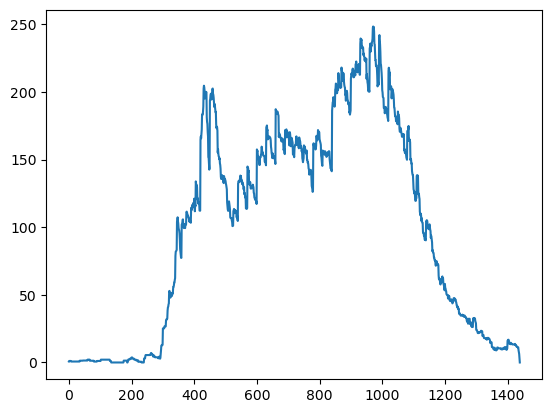

In [66]:
driving_distance_df.sum().plot()

In [67]:
"""
"Creates a DataFrame with all minutes of the day as columns and, for each ID_{Year_}PERSNR_BERTAG, the kW consumed in that minute.
"""
def set_driving_energyconsumption(row):
    list_driving_energy = [0 for _ in range(1440)]
    # Iterate through each trip.
    for start_time, end_time, trip_energy in zip(row["ABZEIT_minutes"], row["ANZEIT_minutes"], row["ENERGY_kWh"]):
        # Calculate the duration of the trip in minutes.
        trip_duration = end_time - start_time
        # Calculate the average kW per minute.
        energy_per_minute = trip_energy / trip_duration * 60
        # Assign the average distance to each minute of the trip.
        for minute in range(int(start_time), int(end_time)):
            list_driving_energy[minute] = energy_per_minute
    return pd.Series(list_driving_energy)

# Apply the function to the DataFrame.
driving_power_df = complete_df.apply(set_driving_energyconsumption, axis=1)
driving_power_df.columns = [i for i in range(1440)]

In [68]:
driving_power_df.loc[["9311060266_2020_2_3", "9311060266_2020_2_4"], 390:400]

,390,391,392,393,394,395,396,397,398,399,400
ID_PERSNR_BERTAG,,,,,,,,,,,
9311060266_2020_2_3,0.0,0.0,0.0,11.81976,11.81976,11.81976,11.81976,11.81976,11.81976,11.81976,11.81976
9311060266_2020_2_4,0.0,0.0,0.0,0.00000,0.00000,11.12448,11.12448,11.12448,11.12448,11.12448,11.12448


In [69]:
driving_distance_df.loc[["9311060266_2020_2_3", "9311060266_2020_2_4"], 390:400]*spec_consump["2030"]*60

,390,391,392,393,394,395,396,397,398,399,400
ID_PERSNR_BERTAG,,,,,,,,,,,
9311060266_2020_2_3,0.0,0.0,0.0,11.81976,11.81976,11.81976,11.81976,11.81976,11.81976,11.81976,11.81976
9311060266_2020_2_4,0.0,0.0,0.0,0.00000,0.00000,11.12448,11.12448,11.12448,11.12448,11.12448,11.12448


Both calculation methods work.

# Loading Profiles
Creating the dictionary "load" that contains a DataFrame for every charging_combination.

It should be named "load_profiles" or something. Unfortunately renaming "load" would have been to much effort as the word load is very common, also when not the dictionary is not meant.



In [70]:
""""""""""""""""""""""""""""""""""""""
""" Determine Load Profiles """
""""""""""""""""""""""""""""""""""""""
load = {}
for charge in charging_combinations:
    load[str(charge).replace(" ", "")] = pd.DataFrame(np.zeros((len(range(24*60)), len([(i,j) for i in complete_df.index for j in [1,2,3]]))),
                                                      columns=pd.MultiIndex.from_tuples([(i,j) for i in complete_df.index for j in [1,2,3]]),
                                                      index=range(24*60))
    for col in trip_chain_df.loc[complete_df[~pd.isna(complete_df["charging_kWh_"+str(charge).replace(" ","")])].index].index:
        for num_fahrt in range(len(complete_df.loc[col, "ANZEIT_minutes"])):
            for num_hour in range(len(complete_df.loc[col, "charging_kWh_"+str(charge).replace(" ","")][num_fahrt])):
                try:
                    load[str(charge).replace(" ", "")].iloc[load[str(charge).replace(" ","")].index.to_list().index(complete_df.loc[col,"ANZEIT_minutes"][num_fahrt])+num_hour][(col,complete_df.loc[col,"ZWECK"][num_fahrt])]       += complete_df.loc[col,"charging_kWh_"+str(charge).replace(" ","")][num_fahrt][num_hour]*60
                except:
                    load[str(charge).replace(" ", "")].iloc[load[str(charge).replace(" ","")].index.to_list().index(complete_df.loc[col,"ANZEIT_minutes"][num_fahrt])+num_hour-60*24][(col,complete_df.loc[col,"ZWECK"][num_fahrt])] += complete_df.loc[col,"charging_kWh_"+str(charge).replace(" ","")][num_fahrt][num_hour]*60
# check maximum load
check_max_load = False
if check_max_load:
    for charge in charging_combinations:
        check = load[str(charge).replace(" ","")].unstack().sort_values().copy()
        print(charge,":",len(check[check>charging_power]),"of",len(check),"above max power")

In [71]:
"""
Plotting der Summe aller Load Profles
"""
def plot_scenarios_sum(load, charging_combinations):
    # Calculate the number of rows for the subplots.
    nrows = int(np.ceil(len(charging_combinations) / 4))
    # Create the figure and axes for the subplots
    fig, axs = plt.subplots(nrows, 4, figsize=(20, 5*nrows))
    # Flatten the axs array in case there's only one row
    axs = axs.flatten()
    # Loop through each scenario in the charging combinations
    for i, scenario in enumerate(charging_combinations):
        # Convert the scenario tuple to a string and remove spaces
        scenario_str = str(scenario).replace(" ", "")
        # Sum the values for this scenario and plot them
        load[scenario_str].groupby(level=1, axis=1).sum().plot(ax=axs[i])
        # Set the subplot title to the scenario
        axs[i].set_title(scenario_str)
    # Remove any unused subplots
    for j in range(i+1, nrows*4):
        fig.delaxes(axs[j])
    # Adjust layout and show the plot
    plt.tight_layout()
    plt.show()

if printPlots:
    plot_scenarios_sum(load, charging_combinations)

### Check
Check that the load matches the consumption and that the load scenarios are also correct.

In [72]:
dp = driving_power_df.T.copy()
checkDF = pd.DataFrame()
# Iterate through all keys in your DataFrame 'dp'.
for key in dp.keys():
    # Calculate the sums for each scenario and store them in a temporary list.
    temp = []
    temp.append(load["(1,0,0)"][key][1].sum())
    temp.append(load["(0,1,0)"][key][2].sum())
    temp.append(load["(0,0,1)"][key][3].sum())
    temp.append(load["(0,1,1)"][key][2].sum() + load["(0,1,1)"][key][3].sum())
    temp.append(load["(1,1,0)"][key][1].sum() + load["(1,1,0)"][key][2].sum())
    temp.append(load["(1,0,1)"][key][1].sum() + load["(1,0,1)"][key][3].sum())
    temp.append(load["(1,1,1)"][key][1].sum() + load["(1,1,1)"][key][2].sum() + load["(1,1,1)"][key][3].sum())
    temp.append(dp[key].sum())
    
    checkDF = pd.concat([checkDF, pd.DataFrame([temp], columns=["(1,0,0)", "(0,1,0)", "(0,0,1)", "(0,1,1)", "(1,1,0)", "(1,0,1)","(1,1,1)", "driving_power"], index=[key])])
    
# Create a new column 'match' that is True if 'dp' matches one of the other columns, and False if not.
checkDF['match'] = ((checkDF["driving_power"] == checkDF["(1,0,0)"]) | (checkDF["driving_power"] == checkDF["(0,1,0)"]) | (checkDF["driving_power"] == checkDF["(0,0,1)"]) | (checkDF["driving_power"] == checkDF["(0,1,1)"]) | (checkDF["driving_power"] == checkDF["(1,1,0)"]) | (checkDF["driving_power"] == checkDF["(1,1,1)"]))
# Create a new column 'match' that is True if 'dp' matches one of the other columns (up to 6 decimal places), and False if not.
checkDF['rounded_match'] = ((checkDF["driving_power"].round(6) == checkDF["(1,0,0)"].round(6)) | (checkDF["driving_power"].round(6) == checkDF["(0,1,0)"].round(6)) | (checkDF["driving_power"].round(6) == checkDF["(0,0,1)"].round(6)) | (checkDF["driving_power"].round(6) == checkDF["(0,1,1)"].round(6)) | (checkDF["driving_power"].round(6) == checkDF["(1,1,0)"].round(6)) | (checkDF["driving_power"].round(6) == checkDF["(1,1,1)"].round(6)))

checkDF

,"(1,0,0)","(0,1,0)","(0,0,1)","(0,1,1)","(1,1,0)","(1,0,1)","(1,1,1)",driving_power,match,rounded_match
5301064363_2020_1_3,0.000000,425.511365,425.511365,425.511365,425.511365,425.511365,425.511365,425.511365,False,True
5301064363_2020_1_4,47.279041,47.279041,0.000000,47.279041,47.279041,47.279041,47.279041,47.279041,True,True
5301064363_2020_1_5,0.000000,496.429926,496.429926,496.429926,496.429926,496.429926,496.429926,496.429926,True,True
5301064363_2020_1_6,47.279041,47.279041,0.000000,47.279041,47.279041,47.279041,47.279041,47.279041,True,True
5301064363_2020_1_7,47.279041,47.279041,0.000000,47.279041,47.279041,47.279041,47.279041,47.279041,True,True
...,...,...,...,...,...,...,...,...,...,...
9311062615_2020_2_4,0.000000,23.639520,23.639520,23.639520,23.639520,23.639520,23.639520,23.639520,True,True
9311062615_2020_2_6,590.988007,590.988007,0.000000,590.988007,590.988007,590.988007,590.988007,590.988007,True,True
9311062783_2020_1_1,0.000000,118.197601,118.197601,118.197601,118.197601,118.197601,118.197601,118.197601,False,True
9311062783_2020_1_4,0.000000,94.558081,94.558081,94.558081,94.558081,94.558081,94.558081,94.558081,False,True


In [73]:
combis = ["(1,0,0)", "(0,1,0)", "(0,0,1)", "(0,1,1)", "(1,1,0)", "(1,0,1)","(1,1,1)"]

#### Load values != Driving Power

In [74]:
matches = []
for combX in combis:
    match_count = (checkDF["driving_power"].round(6) == checkDF[combX].round(6)).sum()
    matches.append((combX, match_count))
matches.sort(key=lambda x: x[1], reverse=True)

# Output the number of matches for 'match' and 'rounded_match'.
print(f"In {checkDF['match'].sum()} out of {len(checkDF)} entries, at least one scenario matches the driving power exactly.")
print(f"In {checkDF['rounded_match'].sum()} out of {len(checkDF)} entries, at least one scenario matches the driving power to 6 decimal places.")
print("")
# Output the number of matches for each scenario.
for combX, match_count in matches:
    print(f"In {match_count} out of {len(checkDF)} entries, {combX} matches the driving power (to 6 decimal places).")


In 2351 out of 3573 entries, at least one scenario matches the driving power exactly.
In 3564 out of 3573 entries, at least one scenario matches the driving power to 6 decimal places.

In 3541 out of 3573 entries, (1,1,1) matches the driving power (to 6 decimal places).
In 3519 out of 3573 entries, (0,1,1) matches the driving power (to 6 decimal places).
In 3427 out of 3573 entries, (1,1,0) matches the driving power (to 6 decimal places).
In 3380 out of 3573 entries, (0,1,0) matches the driving power (to 6 decimal places).
In 2995 out of 3573 entries, (1,0,1) matches the driving power (to 6 decimal places).
In 1854 out of 3573 entries, (0,0,1) matches the driving power (to 6 decimal places).
In 1399 out of 3573 entries, (1,0,0) matches the driving power (to 6 decimal places).


#### Fall: Load values < Driving Power
This case is logically understandable when the car doesn't have enough charging time.
It also makes sense that this occurs more frequently when the cars can only charge at one location (e.g., 0,0,1), and less frequently when they can charge everywhere (1,1,1).

In [75]:
matches = []
for combX in combis:
    match_count = (checkDF["driving_power"].round(6) > checkDF[combX].round(6)).sum()
    matches.append((combX, match_count))
matches.sort(key=lambda x: x[1], reverse=False)
# Output the number of matches for each scenario.
for combX, match_count in matches:
    print(f"In {match_count} out of {len(checkDF)} entries, {combX} is less than the driving power (to 6 decimal places).")

In 32 out of 3573 entries, (1,1,1) is less than the driving power (to 6 decimal places).
In 54 out of 3573 entries, (0,1,1) is less than the driving power (to 6 decimal places).
In 146 out of 3573 entries, (1,1,0) is less than the driving power (to 6 decimal places).
In 193 out of 3573 entries, (0,1,0) is less than the driving power (to 6 decimal places).
In 578 out of 3573 entries, (1,0,1) is less than the driving power (to 6 decimal places).
In 1719 out of 3573 entries, (0,0,1) is less than the driving power (to 6 decimal places).
In 2174 out of 3573 entries, (1,0,0) is less than the driving power (to 6 decimal places).


#### Fall: Load values > Driving Power
That shouldn't actually happen.

In [76]:
matches = []
for combX in combis:
    match_count = (checkDF["driving_power"].round(6) < checkDF[combX].round(6)).sum()
    matches.append((combX, match_count))

matches.sort(key=lambda x: x[1], reverse=False)

for combX, match_count in matches:
    print(f"In {match_count} out of {len(checkDF)} entries, {combX} is greater than the driving power (to 6 decimal places).")


In 0 out of 3573 entries, (1,0,0) is greater than the driving power (to 6 decimal places).
In 0 out of 3573 entries, (0,1,0) is greater than the driving power (to 6 decimal places).
In 0 out of 3573 entries, (0,0,1) is greater than the driving power (to 6 decimal places).
In 0 out of 3573 entries, (0,1,1) is greater than the driving power (to 6 decimal places).
In 0 out of 3573 entries, (1,1,0) is greater than the driving power (to 6 decimal places).
In 0 out of 3573 entries, (1,0,1) is greater than the driving power (to 6 decimal places).
In 0 out of 3573 entries, (1,1,1) is greater than the driving power (to 6 decimal places).


#### Case: Individual scenarios are smaller than combined ones (e.g., 1,1,1 < 1,1).

In [77]:
matches = []
for combX in ["(1,0,0)", "(0,1,0)", "(0,0,1)", "(0,1,1)", "(1,1,0)", "(1,0,1)"]:
    match_count = (checkDF["(1,1,1)"].round(6) < checkDF[combX].round(6)).sum()
    matches.append((combX, match_count))

matches.sort(key=lambda x: x[1], reverse=False)

for combX, match_count in matches:
    print(f"In {match_count} out of {len(checkDF)} entries, {combX} is greater than (1,1,1) (to 6 decimal places).")

smaller3 = False
for combX in ["(1,0,0)", "(0,1,0)", "(0,0,1)", "(0,1,1)", "(1,1,0)", "(1,0,1)"]:
    smaller3 = smaller3 | (checkDF["(1,1,1)"].round(6) < checkDF[combX].round(6))
print("There are " + str(checkDF[smaller3].shape[0]) + " entries where (1,1,1) is smaller than one of the other scenarios.")
      
smaller2_1 = False
for combX in ["(1,0,0)", "(0,1,0)"]:
    smaller2_1 = smaller2_1 | (checkDF["(1,1,0)"].round(6) < checkDF[combX].round(6)) 
print("There are " + str(checkDF[smaller2_1].shape[0]) + " entries where (1,1,0) is smaller than one of the individual scenarios.")
      
smaller2_2= False
for combX in ["(1,0,0)", "(0,0,1)"]:
    smaller2_2 = smaller2_2 | (checkDF["(1,0,1)"].round(6) < checkDF[combX].round(6)) 
print("There are " + str(checkDF[smaller2_2].shape[0]) + " entries where (1,0,1) is smaller than one of the individual scenarios.")
      
smaller2_3= False
for combX in ["(0,1,0)", "(0,0,1)"]:
    smaller2_3 = smaller2_3 | (checkDF["(0,1,1)"].round(6) < checkDF[combX].round(6)) 
print("There are " + str(checkDF[smaller2_3].shape[0]) + " entries where (0,1,1) is smaller than one of the individual scenarios.")
      
combined = smaller3| smaller2_1 | smaller2_2 | smaller2_3
print("There are a total of " + str(checkDF[combined].shape[0]) + " entries where at least one of these incorrect situations occurs.")



In 1 out of 3573 entries, (1,0,0) is greater than (1,1,1) (to 6 decimal places).
In 1 out of 3573 entries, (1,0,1) is greater than (1,1,1) (to 6 decimal places).
In 3 out of 3573 entries, (0,0,1) is greater than (1,1,1) (to 6 decimal places).
In 8 out of 3573 entries, (1,1,0) is greater than (1,1,1) (to 6 decimal places).
In 9 out of 3573 entries, (0,1,1) is greater than (1,1,1) (to 6 decimal places).
In 19 out of 3573 entries, (0,1,0) is greater than (1,1,1) (to 6 decimal places).
There are 23 entries where (1,1,1) is smaller than one of the other scenarios.
There are 12 entries where (1,1,0) is smaller than one of the individual scenarios.
There are 21 entries where (1,0,1) is smaller than one of the individual scenarios.
There are 13 entries where (0,1,1) is smaller than one of the individual scenarios.
There are a total of 41 entries where at least one of these incorrect situations occurs.


#### Restrict the data
Exclude entries with these incorrect situations.

In [78]:
relevantIdx = checkDF.loc[~combined].index

# Iterate through all keys in your 'load' dictionary.
for key in load.keys():
    # Retrieve the current DataFrame.
    df = load[key]    
    # Erstellen Sie eine Liste der relevanten Spalten
    relevant_columns = [col for col in df.columns if col[0] in relevantIdx]  
    # Create a list of the relevant columns.
    df = df[relevant_columns]
    # Update the 'load' dictionary with the new DataFrame.
    load[key] = df
print("All incorrect entries have been removed from 'load'.")

beforeCount = driving_power_df.shape[0]
driving_power_df = driving_power_df.loc[relevantIdx]
afterCount = driving_power_df.shape[0]
print(str(beforeCount - afterCount) + " entries have been removed from driving_power_df.")

beforeCount = complete_df.shape[0]
complete_df = complete_df.loc[relevantIdx]
afterCount = complete_df.shape[0]
print(str(beforeCount - afterCount) + " entries have been removed from completeDF.")

beforeCount = park_time_by_location_df.shape[0]
park_time_by_location_df = park_time_by_location_df.loc[relevantIdx]
afterCount = park_time_by_location_df.shape[0]
print(str(beforeCount - afterCount) + " entries have been removed from park_time_by_location_df.")



All incorrect entries have been removed from 'load'.
41 entries have been removed from driving_power_df.
41 entries have been removed from completeDF.
42 entries have been removed from park_time_by_location_df.


### Pickle Save [Checkpoint 3]
Final Checpoint saving, "park_time_by_location_df" and the dictionary "load".


In [79]:
if savingCP3:
    park_time_by_location_df.to_pickle("Output/temp_saves/park_time_by_location_df_cp3.pickle")
    with open("load_cp3.pickle", "wb") as file:
        pickle.dump(load, file)
    print("Saved park_time_by_location_df and load to /Output/temp_saves")
    
if loadingCP3:
    park_time_by_location_df = pd.read_pickle("./Output/temp_saves/park_time_by_location_df_cp3.pickle")
    with open("load_cp3.pickle", "rb") as file:
        load = pickle.load(file)
    print("Load park_time_by_location_df and load from /Output/temp_saves")

In [80]:
park_time_by_location_df

,0,1,2,3,4,5,6,7,8,9,...,1430,1431,1432,1433,1434,1435,1436,1437,1438,1439
5301064363_2020_1_3,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5301064363_2020_1_4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5301064363_2020_1_5,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5301064363_2020_1_6,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
5301064363_2020_1_7,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
9311062615_2020_2_4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
9311062615_2020_2_6,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
9311062783_2020_1_1,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2
9311062783_2020_1_4,2,2,2,2,2,2,2,2,2,2,...,2,2,2,2,2,2,2,2,2,2


## Clustering

In [81]:
"""
Note: WD=Weekday=1, WE=Weekend=0
"""
def only_home_parking(val):
    if val == 2:
        return 1
    else:
        return 0

def cluster(complete_df, park_time_by_location_df, n):
    # Only Home Parking
    park_time_home = park_time_by_location_df.applymap(only_home_parking)
    # Weekday/ Weekend
    filteredListWD = complete_df[complete_df['WOTAG'] == 1].index
    filteredListWE = complete_df[complete_df['WOTAG'] == 0].index
    parking_df_WD = park_time_home[park_time_home.index.isin(filteredListWD)].copy()
    parking_df_WE = park_time_home[park_time_home.index.isin(filteredListWE)].copy()
    
    #Cluster
    kmedoids_instanceWD = KMedoids(n_clusters=n, random_state=30, init='k-medoids++').fit(parking_df_WD)
    parking_df_WD["cluster"] = kmedoids_instanceWD.labels_
    kmedoids_instanceWE = KMedoids(n_clusters=n, random_state=30, init='k-medoids++').fit(parking_df_WE)
    parking_df_WE["cluster"] = kmedoids_instanceWE.labels_
    
    parking_df_c = pd.concat([parking_df_WD, parking_df_WE])
    complete_df_c = complete_df.join(parking_df_c["cluster"])
    
    #Get Centroids
    centroids_WD = []
    centroids_WE = []
    for i in range(n):
        centroids_WD.append(parking_df_WD.index[kmedoids_instanceWD.medoid_indices_[i]])
        centroids_WE.append(parking_df_WE.index[kmedoids_instanceWE.medoid_indices_[i]])
    
    return parking_df_c, complete_df_c, centroids_WD, centroids_WE, park_time_home

parking_df_c, complete_df_c, centroids_WD, centroids_WE, park_time_home = cluster(complete_df, park_time_by_location_df, clusters)

In [82]:
parking_df_c["cluster"].value_counts()

1    946
0    475
4    359
3    321
9    293
5    276
6    276
7    243
2    183
8    160
Name: cluster, dtype: int64

## Aggregate charging profiles.

In [83]:
dict_loadprofiles = {}
for num, charge in enumerate(charging_combinations):
    dict_loadprofiles["_".join(list(compress(("Arbeitsplatz", "Zuhause", "Öffentlich"), charge)))] = {}
    for day in [0, 1]:
        dict_loadprofiles["_".join(list(compress(("Arbeitsplatz", "Zuhause", "Öffentlich"), charge)))][days[day]] = {}
        for bik, i in enumerate(complete_df_c.BIK.sort_values().drop_duplicates()):
            loadprofiles_all = pd.DataFrame()
            # Iterate over the different profile components (workplace, home, public)
            for j in [1,2,3]:
                loadprofiles = (load[str(charge).replace(" ", "")][(complete_df_c[(complete_df_c.BIK == i) & (complete_df_c.WOTAG == day)].index)].loc(axis=1)[:, j] / len(load[str(charge).replace(" ", "")][(complete_df_c[(complete_df_c.BIK == i) & (complete_df_c.WOTAG == day) & (~complete_df_c["ENERGY_kWh_" + str(charge).replace(" ", "")].isna())].index)].columns.get_level_values(0).drop_duplicates()))
                loadprofiles.columns = loadprofiles.columns.droplevel(1)
                loadprofiles.loc["cluster", :] = complete_df_c.loc[loadprofiles.columns, "cluster"]
                loadprofiles.columns = loadprofiles.loc["cluster", :].astype(int)
                loadprofiles = loadprofiles.groupby(level=0, axis=1).sum().drop(index=["cluster"])
                #loadprofiles *= cluster_centroids[day]  # NNA: evtl. auskommentieren
                loadprofiles_all = loadprofiles_all.add(loadprofiles, fill_value=0)
            
            dict_loadprofiles["_".join(list(compress(("Arbeitsplatz", "Zuhause", "Öffentlich"), charge)))][days[day]][rename_gemeinde.set_index("Code_new")["Stadt- und Gemeindetyp"].drop_duplicates().loc[i]] = loadprofiles_all.copy()
            

<Axes: >

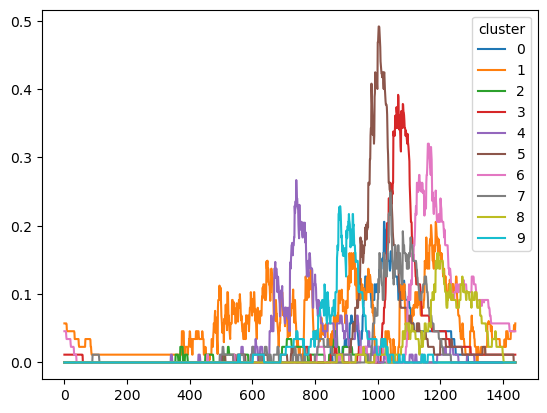

In [84]:
dict_loadprofiles["Zuhause"]["Wochentag"]["Große Großstadt"].plot()

<Axes: >

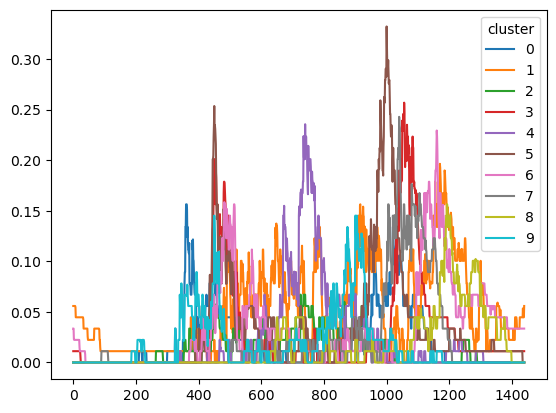

In [85]:
dict_loadprofiles["Arbeitsplatz_Zuhause"]["Wochentag"]["Große Großstadt"].plot()

<Axes: >

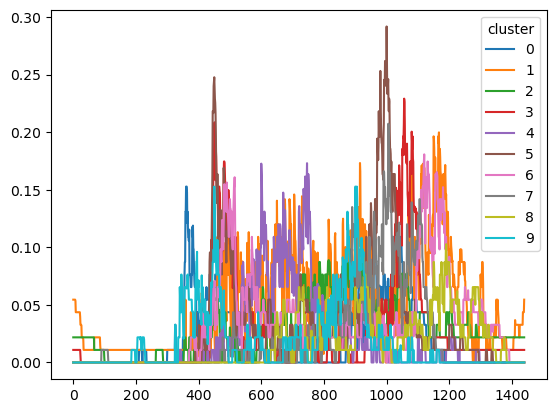

In [86]:
dict_loadprofiles["Arbeitsplatz_Zuhause_Öffentlich"]["Wochentag"]["Große Großstadt"].plot()

## Aggregate driving profiles
How many kilometers, or how many kilowatts per minute?

In [87]:
dict_drivingprofiles = {}
unique_bik_values = complete_df_c.BIK.sort_values().drop_duplicates()

for num, charge in enumerate(charging_combinations):
    dict_drivingprofiles["_".join(list(compress(("Arbeitsplatz", "Zuhause", "Öffentlich"), charge)))] = {}
    for day in [0, 1]:
        dict_drivingprofiles["_".join(list(compress(("Arbeitsplatz", "Zuhause", "Öffentlich"), charge)))][days[day]] = {}
        for bik, i in enumerate(unique_bik_values):
            condition = (complete_df_c.BIK == i) & (complete_df_c.WOTAG == day)
            relevant_df = complete_df_c[condition]
            relevant_driving_power_df = driving_power_df.T[relevant_df.index]

            unique_columns = relevant_driving_power_df.columns.drop_duplicates()
            drivingprofiles = relevant_driving_power_df / len(unique_columns)

            drivingprofiles.loc["cluster", :] = complete_df_c.loc[drivingprofiles.columns, "cluster"]
            drivingprofiles.columns = drivingprofiles.loc["cluster", :].astype(int)
            drivingprofiles = drivingprofiles.groupby(level=0, axis=1).sum().drop(index=["cluster"])

            gemeindetyp = rename_gemeinde.set_index("Code_new")["Stadt- und Gemeindetyp"].drop_duplicates().loc[i]
            dict_drivingprofiles["_".join(list(compress(("Arbeitsplatz", "Zuhause", "Öffentlich"), charge)))][days[day]][rename_gemeinde.set_index("Code_new")["Stadt- und Gemeindetyp"].drop_duplicates().loc[i]] = drivingprofiles.copy()
            

### Let’s compare the charging profiles of the different scenarios with the driving profile.

In [88]:
# Weekday in a large city
df = pd.DataFrame()
df['driving_profiles'] = dict_drivingprofiles["Arbeitsplatz_Zuhause"]["Wochentag"]["Große Großstadt"].sum()
df['lp_Arbeitsplatz_Zuhause_Öffentlich'] = dict_loadprofiles["Arbeitsplatz_Zuhause_Öffentlich"]["Wochentag"]["Große Großstadt"].sum()
df['lp_Arbeitsplatz_Zuhause'] = dict_loadprofiles["Arbeitsplatz_Zuhause"]["Wochentag"]["Große Großstadt"].sum()
df['lp_Arbeitsplatz_Öffentlich'] = dict_loadprofiles["Arbeitsplatz_Öffentlich"]["Wochentag"]["Große Großstadt"].sum()
df['lp_Zuhause_Öffentlich'] = dict_loadprofiles["Zuhause_Öffentlich"]["Wochentag"]["Große Großstadt"].sum()
df['lp_Zuhause'] = dict_loadprofiles["Zuhause"]["Wochentag"]["Große Großstadt"].sum()
df['lp_Öffentlich'] = dict_loadprofiles["Öffentlich"]["Wochentag"]["Große Großstadt"].sum()
df['lp_Arbeitsplatz'] = dict_loadprofiles["Arbeitsplatz"]["Wochentag"]["Große Großstadt"].sum()
df

,driving_profiles,lp_Arbeitsplatz_Zuhause_Öffentlich,lp_Arbeitsplatz_Zuhause,lp_Arbeitsplatz_Öffentlich,lp_Zuhause_Öffentlich,lp_Zuhause,lp_Öffentlich,lp_Arbeitsplatz
cluster,,,,,,,,
0,26.748936,26.802010,27.427843,31.017710,27.152187,28.083603,4.620655,64.019966
1,73.639446,73.785556,75.508468,44.995153,74.749589,77.313764,65.819753,11.696521
2,47.823218,39.416789,17.592843,45.616675,35.872675,5.852133,63.513894,35.520900
3,37.909833,37.985051,38.872011,36.453986,38.481338,39.801384,12.740316,65.610872
4,29.547060,29.605685,30.296985,24.512093,29.992493,31.021341,37.249002,5.055608
5,46.960726,47.053902,48.152623,40.158687,47.668677,49.303881,16.464993,78.091643
6,55.948425,47.642545,48.755011,49.409583,48.265010,49.920671,18.312808,94.742940
7,29.286089,29.344196,30.029391,18.629353,29.727588,30.747349,26.568765,7.178684
8,23.355144,23.401483,23.947914,22.875511,23.707231,24.520473,24.405905,19.760286


In [89]:
# Weekend in a smaller mid-sized city
df = pd.DataFrame()
df['driving_profiles'] = dict_drivingprofiles["Arbeitsplatz_Zuhause"]["Wochenende"]["Kleinere Mittelstadt"].sum()
df['lp_Arbeitsplatz_Zuhause_Öffentlich'] = dict_loadprofiles["Arbeitsplatz_Zuhause_Öffentlich"]["Wochenende"]["Kleinere Mittelstadt"].sum()
df['lp_Arbeitsplatz_Zuhause'] = dict_loadprofiles["Arbeitsplatz_Zuhause"]["Wochenende"]["Kleinere Mittelstadt"].sum()
df['lp_Arbeitsplatz_Öffentlich'] = dict_loadprofiles["Arbeitsplatz_Öffentlich"]["Wochenende"]["Kleinere Mittelstadt"].sum()
df['lp_Zuhause_Öffentlich'] = dict_loadprofiles["Zuhause_Öffentlich"]["Wochenende"]["Kleinere Mittelstadt"].sum()
df['lp_Zuhause'] = dict_loadprofiles["Zuhause"]["Wochenende"]["Kleinere Mittelstadt"].sum()
df['lp_Öffentlich'] = dict_loadprofiles["Öffentlich"]["Wochenende"]["Kleinere Mittelstadt"].sum()
df['lp_Arbeitsplatz'] = dict_loadprofiles["Arbeitsplatz"]["Wochenende"]["Kleinere Mittelstadt"].sum()
df

,driving_profiles,lp_Arbeitsplatz_Zuhause_Öffentlich,lp_Arbeitsplatz_Zuhause,lp_Arbeitsplatz_Öffentlich,lp_Zuhause_Öffentlich,lp_Zuhause,lp_Öffentlich,lp_Arbeitsplatz
cluster,,,,,,,,
0,97.935155,97.935155,107.116576,44.786146,97.935155,107.116576,46.476189,0.000000
1,189.031735,189.031735,8.126085,240.585845,189.031735,8.126085,249.664556,0.000000
2,116.981855,116.981855,127.948903,75.818389,116.981855,127.948903,76.850742,48.461017
3,41.943263,41.943263,45.875444,35.545242,41.943263,45.875444,36.886572,0.000000
4,91.991505,91.991505,100.615708,50.932421,91.991505,100.615708,52.854399,0.000000
5,3.073138,3.073138,3.361244,3.911266,3.073138,3.361244,2.899186,30.731376
6,15.433230,15.433230,16.880095,19.642292,15.433230,16.880095,20.383511,0.000000
7,25.294287,25.294287,27.665626,15.859969,25.294287,27.665626,16.458458,0.000000
8,3.478387,3.478387,3.804485,4.427037,3.478387,3.804485,4.594095,0.000000


## Flex-Profile (positive)
charge less

In [90]:
# Centroids Home Parking Profiles
home_parking_df = park_time_by_location_df.applymap(only_home_parking)
centroids_home_parking = {}
centroids_parking_WD = home_parking_df.loc[centroids_WD].T
centroids_parking_WD.columns = range(clusters)
centroids_home_parking[1] = centroids_parking_WD
centroids_parking_WE = home_parking_df.loc[centroids_WE].T
centroids_parking_WE.columns = range(clusters)
centroids_home_parking[0] = centroids_parking_WE

In [91]:
# Only Combinations with HomeCharching
dict_flex_pos = {}
combinations_home = [i for i in charging_combinations if i[1]==1]

In [92]:
for num,charge in enumerate(combinations_home):
    dict_flex_pos["_".join(list(compress(("Arbeitsplatz","Zuhause","Öffentlich"),charge)))] = {}
    for day in [0,1]:
        dict_flex_pos["_".join(list(compress(("Arbeitsplatz","Zuhause","Öffentlich"),charge)))][days[day]] = {}
        for bik,i in enumerate(complete_df_c.BIK.sort_values().drop_duplicates()):
            flex_pos = (load[str(charge).replace(" ","")][(complete_df_c[(complete_df_c.BIK==i)&(complete_df_c.WOTAG==day)].index)].loc(axis=1)[:,2]/len(load[str(charge).replace(" ","")][(complete_df_c[(complete_df_c.BIK==i)&(complete_df_c.WOTAG==day)&(~complete_df_c["ENERGY_kWh_"+str(charge).replace(" ","")].isna())].index)].columns.get_level_values(0).drop_duplicates()))
            flex_pos.columns = flex_pos.columns.droplevel(1)
            flex_pos.loc["cluster",:] = complete_df_c.loc[flex_pos.columns,"cluster"]
            flex_pos.columns = flex_pos.loc["cluster",:].astype(int)
            flex_pos = flex_pos.groupby(level=0,axis=1).sum().drop(index=["cluster"])
            flex_pos *= centroids_home_parking[day]
            dict_flex_pos["_".join(list(compress(("Arbeitsplatz","Zuhause","Öffentlich"),charge)))][days[day]][rename_gemeinde.set_index("Code_new")["Stadt- und Gemeindetyp"].drop_duplicates().loc[i]] = flex_pos.copy()

<Axes: >

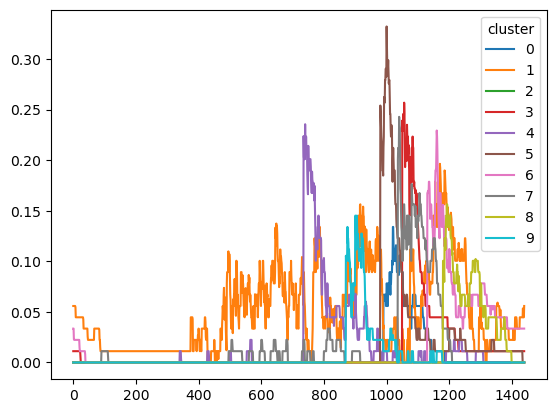

In [93]:
dict_flex_pos["Arbeitsplatz_Zuhause"]["Wochentag"]["Große Großstadt"].plot()

## Flex-Profile (negative)
charge more

In [94]:
dict_flex_neg = {}
combinations_home = [i for i in charging_combinations if i[1]==1]
standzeit = park_time_by_location_df.copy().applymap(only_home_parking)

In [95]:
for num,charge in enumerate(combinations_home):
    dict_flex_neg["_".join(list(compress(("Arbeitsplatz","Zuhause","Öffentlich"),charge)))] = {}
    for day in [0,1]:
        dict_flex_neg["_".join(list(compress(("Arbeitsplatz","Zuhause","Öffentlich"),charge)))][days[day]] = {}
        for bik,i in enumerate(complete_df_c.BIK.sort_values().drop_duplicates()):
            flex_neg = (load[str(charge).replace(" ","")][(complete_df_c[(complete_df_c.BIK==i)&(complete_df_c.WOTAG==day)].index)].loc(axis=1)[:,2])/len(load[str(charge).replace(" ","")][(complete_df_c[(complete_df_c.BIK==i)&(~complete_df_c["ENERGY_kWh_"+str(charge).replace(" ","")].isna())].index)].columns.get_level_values(0).drop_duplicates())
            flex_neg.columns = flex_neg.columns.droplevel(1)
            flex_neg = (flex_neg.max() - flex_neg).mul(standzeit.loc[flex_neg.columns].T)
            flex_neg.loc["cluster",:] = complete_df_c.loc[flex_neg.columns,"cluster"]
            flex_neg.columns = flex_neg.loc["cluster",:].astype(int)
            flex_neg = flex_neg.groupby(level=0,axis=1).sum().drop(index=["cluster"])
            flex_neg *= centroids_home_parking[day]
            dict_flex_neg["_".join(list(compress(("Arbeitsplatz","Zuhause","Öffentlich"),charge)))][days[day]][rename_gemeinde.set_index("Code_new")["Stadt- und Gemeindetyp"].drop_duplicates().loc[i]] = flex_neg.copy()

<Axes: >

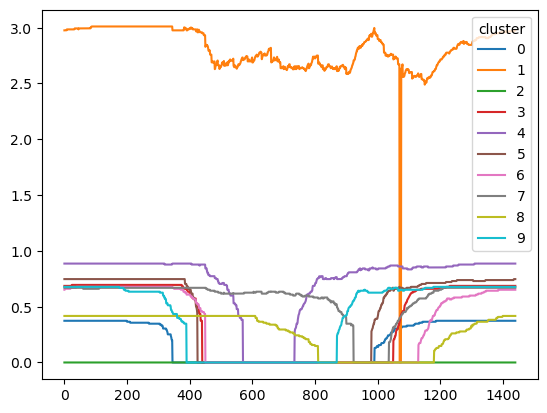

In [96]:
dict_flex_neg["Arbeitsplatz_Zuhause"]["Wochentag"]["Große Großstadt"].plot()

# Excel Export

In [97]:
# load profiles
lp = pd.concat([pd.concat({str(j): pd.concat({str(i): pd.concat(dict_loadprofiles[i][j],axis=1)}, axis=1)},axis=1) for i in dict_loadprofiles for j in dict_loadprofiles[i]],axis=1)
lp.index = pd.date_range("00:00:00","23:59:00",1440)
lp = lp.resample("1h").mean()
lp.index = lp.index.strftime('%H:%M')
lp = lp.reorder_levels([2,0,1,3],axis=1)

In [98]:
# driving profiles
dp = pd.concat([pd.concat({str(j): pd.concat({str(i): pd.concat(dict_drivingprofiles[i][j],axis=1)}, axis=1)},axis=1) for i in dict_drivingprofiles for j in dict_drivingprofiles[i]],axis=1)
dp.index = pd.date_range("00:00:00","23:59:00",1440)
dp = dp.resample("1h").mean()
dp.index = dp.index.strftime('%H:%M')
dp = dp.reorder_levels([2,0,1,3],axis=1)

In [99]:
# pos. flexibility
pos_flex = pd.concat([pd.concat({str(j): pd.concat({str(i): pd.concat(dict_flex_pos[i][j],axis=1)}, axis=1)},axis=1) for i in dict_flex_pos for j in dict_flex_pos[i]],axis=1)
pos_flex.index = pd.date_range("00:00:00","23:59:00",1440)
pos_flex = pos_flex.resample("1h").mean()
pos_flex.index = pos_flex.index.strftime('%H:%M')
pos_flex = pos_flex.reorder_levels([2,0,1,3],axis=1)

In [100]:
# neg. flexibility
neg_flex = pd.concat([pd.concat({str(j): pd.concat({str(i): pd.concat(dict_flex_neg[i][j],axis=1)}, axis=1)},axis=1) for i in dict_flex_neg for j in dict_flex_neg[i]],axis=1)
neg_flex.index = pd.date_range("00:00:00","23:59:00",1440)
neg_flex = neg_flex.resample("1h").mean()
neg_flex.index = neg_flex.index.strftime('%H:%M')
neg_flex = neg_flex.reorder_levels([2,0,1,3],axis=1)

In [101]:
writer = pd.ExcelWriter("output/export_sc" + scenario  + "_cp" + str(charging_power) + "_cluster" + str(clusters) + ".xlsx")

# Write the DataFrames to separate sheets.
lp.to_excel(writer, sheet_name='load')
pos_flex.to_excel(writer, sheet_name='pos_flex')
neg_flex.to_excel(writer, sheet_name='neg_flex')
dp.to_excel(writer, sheet_name='driving')
writer.close()